
# Time series analysis
 Lund University

### Example code 6: examining the powerload data from Helsinki (see also Ex 5.17).
 
 Note: This is an IMPORTANT example!

**Reference:**  
*An Introduction to Time Series Modeling*, 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

Lets have fun!

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.insert(0, os.path.join('..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main'))

from tsa_lth.analysis import plotACFnPACF, box_cox, check_for_significance
from tsa_lth.tests import whiteness_test, monti_test
from tsa_lth.modelling import PEM, filter as tsa_filter

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.0

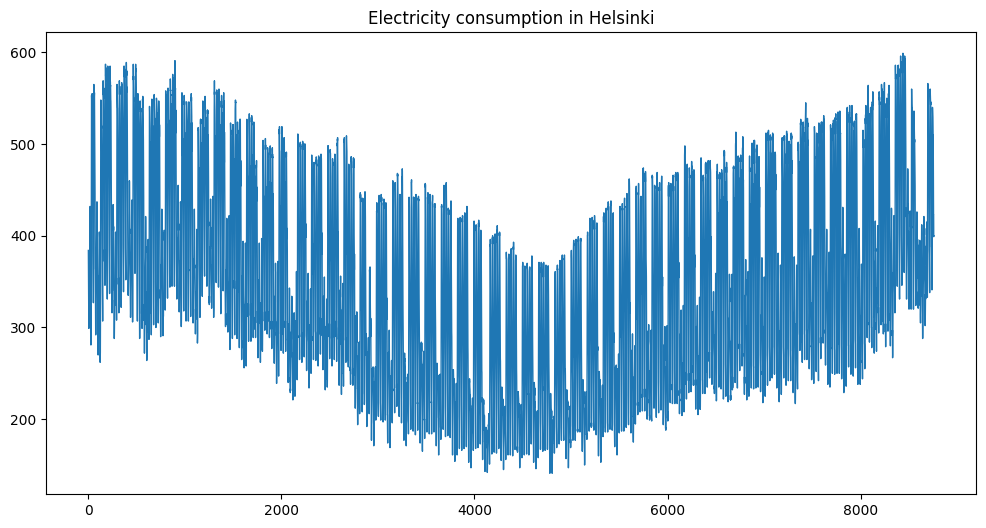

In [15]:
# Load data and examine it.
df = pd.read_csv('../data/helsinki_powerload.csv')
powerload = df['powerload'].values

plt.figure()
plt.plot(powerload)
plt.title('Electricity consumption in Helsinki')
plt.show()

## Should we transform the data?
Note that we examine all the data when making this decision.

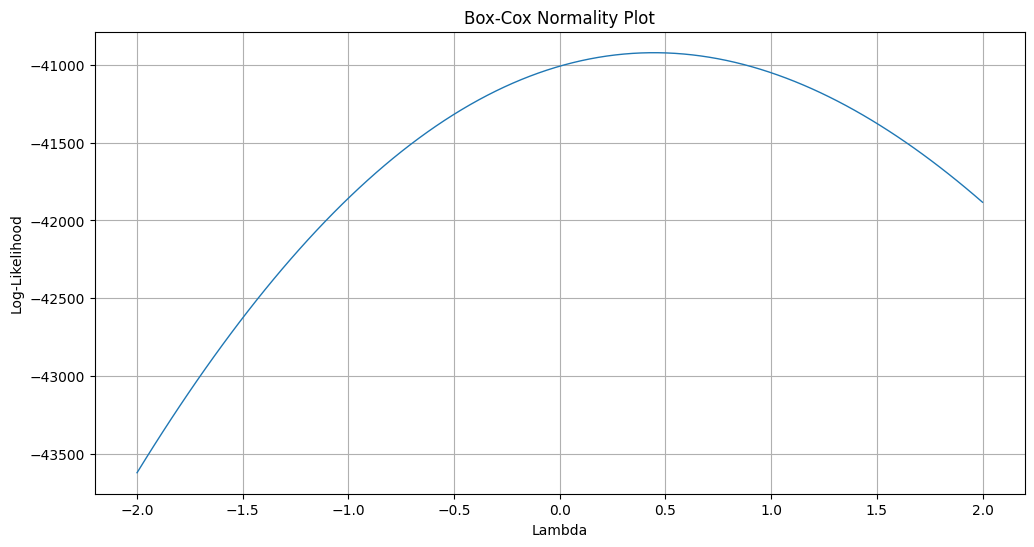

The Box-Cox curve is maximized at 0.45. This suggests that a sqrt or log-transform might be helpful.


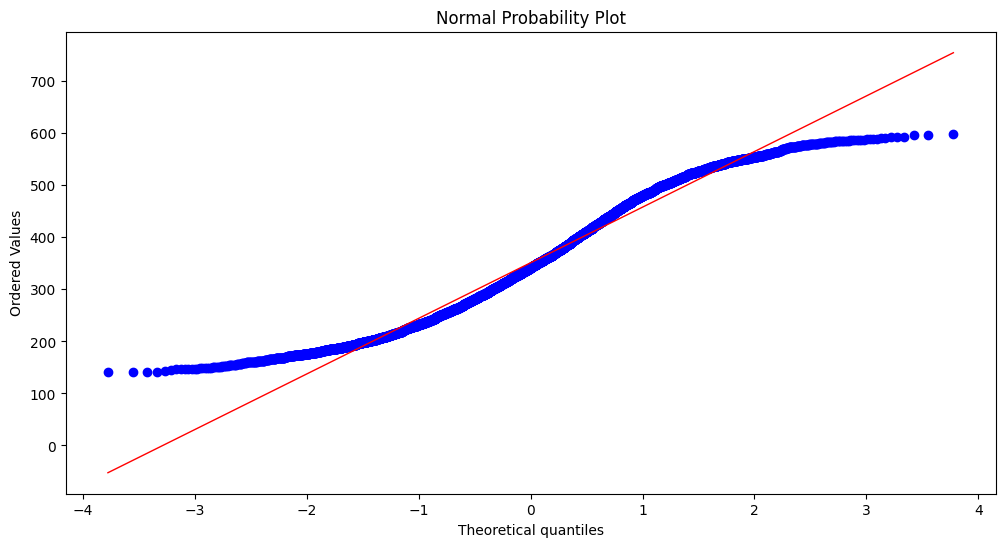

In [16]:
# Use the packaged Box-Cox helper (returns lambda and offset when transform=False)
lambda_max, offsetValue = box_cox(powerload, plotIt=True, transform=False)
print(f'The Box-Cox curve is maximized at {lambda_max:4.2f}. This suggests that a sqrt or log-transform might be helpful.')

plt.figure()
stats.probplot(powerload, dist="norm", plot=plt)
plt.title('Normal Probability Plot')
plt.show()

In [17]:
# Lets transform the data. 
# The difference is small... perhaps we do not need this... Try without!
original = powerload.copy()
powerload = np.log(powerload)           # This is asking for trouble...

## Extract a modelling set.

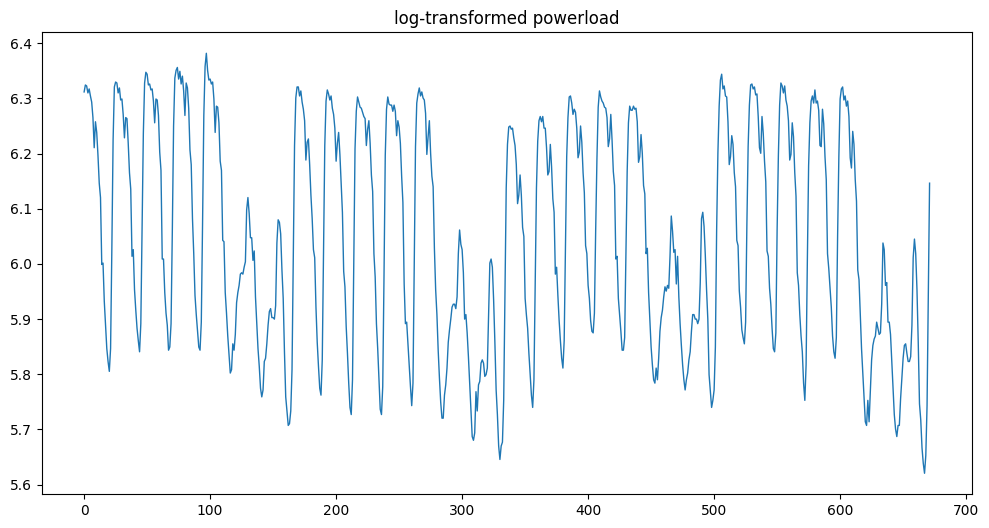

In [18]:
first = 800
last = first + 168*4 - 1               # We select 4 weeks. Does the data seem stable enough?
powerload = powerload[first:last+1]     # Python uses 0-based indexing

plt.figure()
plt.plot(powerload)
plt.title('log-transformed powerload')
plt.show()

## Examine the ACF and PACF.
Note the clear periodicities at 24 and 168 hours. Why is this?

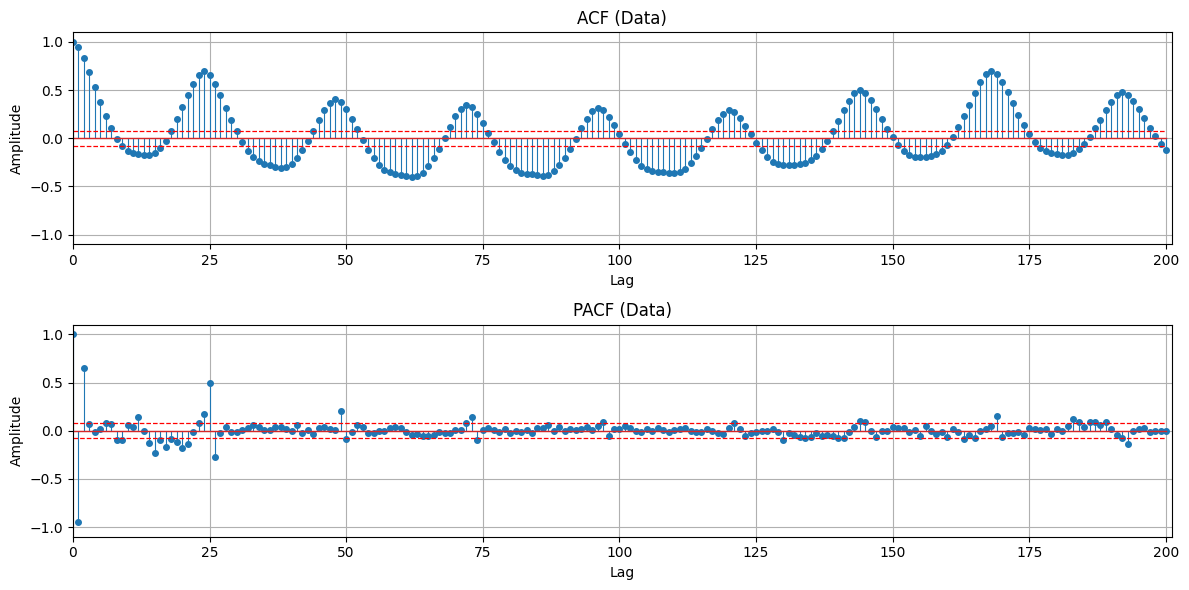

In [19]:
noLags = 200
_=plotACFnPACF(powerload, noLags, 'Data')

## Differentiate to remove the periodicities. Remember to remove the initial samples!

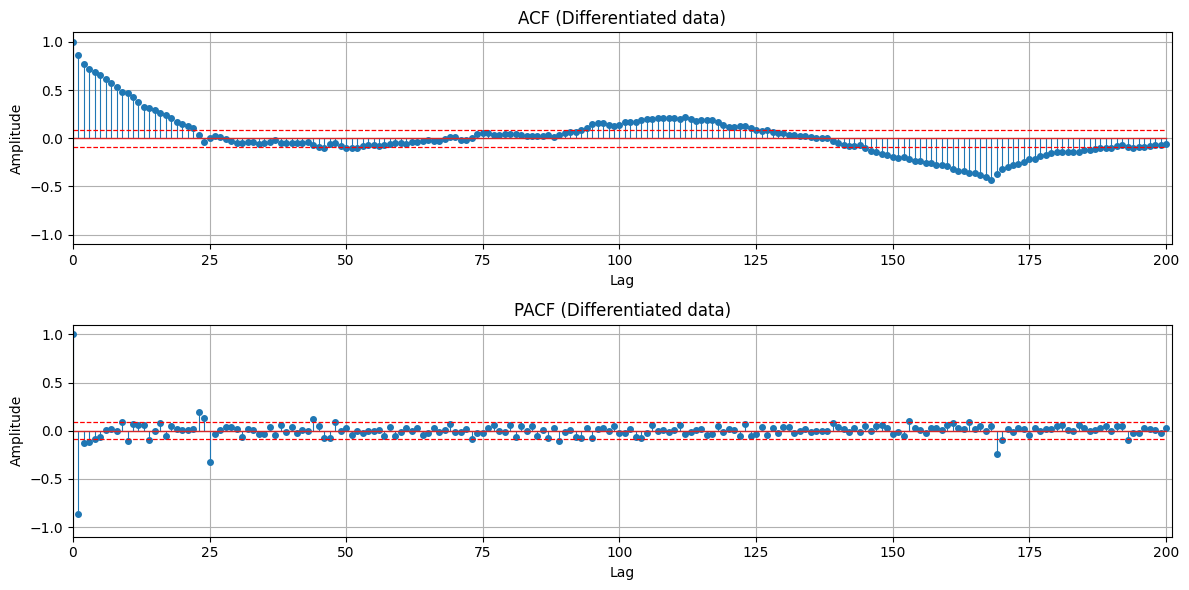

In [20]:
sweek = 168
sday = 24
dayPoly = np.concatenate([[1], np.zeros(sday-1), [-1]])
weekPoly = np.concatenate([[1], np.zeros(sweek-1), [-1]])

powerload = tsa_filter(dayPoly, 1, powerload, remove=True)
powerload = tsa_filter(weekPoly, 1, powerload, remove=True)

_=plotACFnPACF(powerload, noLags, 'Differentiated data')

## Make a first model using PEM class
We begin modelling the AR-part. Note that the first PACF lag is
significant. Lets try using just that.

=== Model 1: AR(1) ===
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.8653(±0.023)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 49.56%
FPE : 0.0  MSE : 0.0
AIC : -2313.573   BIC : -2309.401



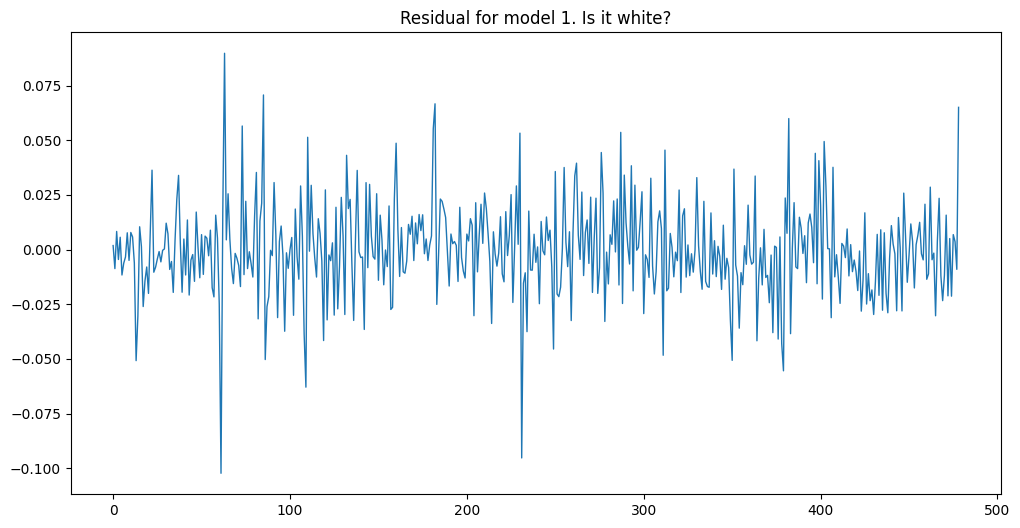

In [21]:
print("=== Model 1: AR(1) ===")
Am =np.array([1, 1])  
Cm =np.array([1])
foundmodel1 = PEM(y=powerload, A=Am, C=Cm) 

result1 = foundmodel1.fit()
result1.summary() #Note the confidence interval on the estimated parameter!

# Compute the residual
ey1 = result1.resid # the initial samples are removed in modeling.py

# Is the residual white?
plt.figure()
plt.plot(ey1)
plt.title('Residual for model 1. Is it white?')
plt.show()

## Lets look at the ACF and PACF.

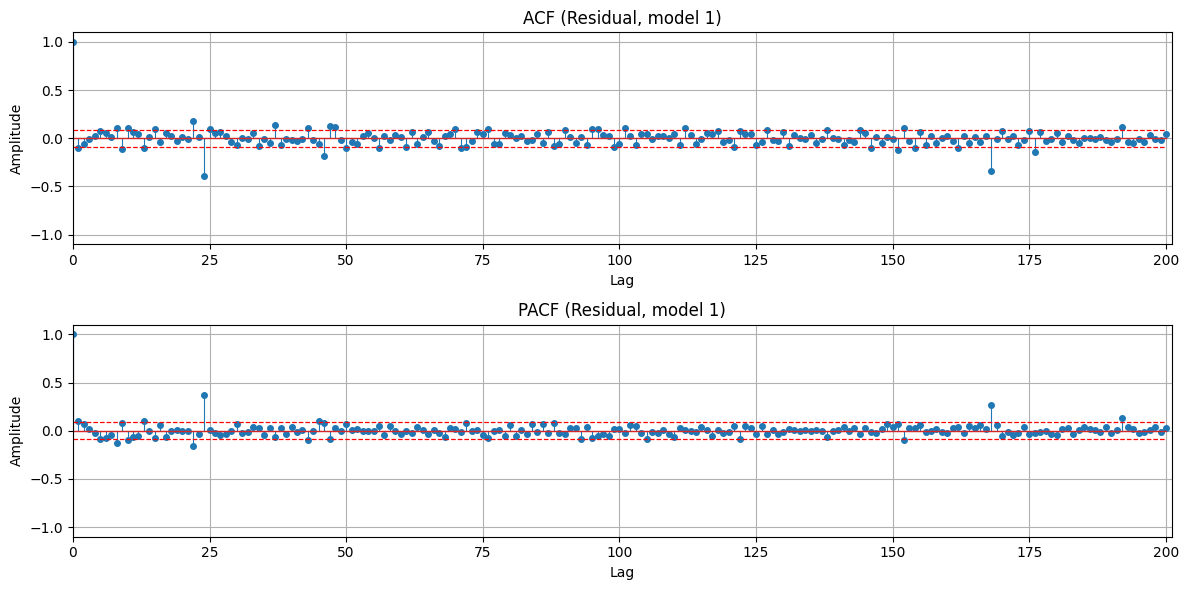

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 140.98 < 37.65)
  McLeod-Li test:        False (white if 74.10 < 37.65)
  Monti test:            False (white if 125.78 < 37.65)
  Sign change test:      True (white if 0.53 in [0.46,0.54])


In [22]:
_=plotACFnPACF(ey1, noLags, 'Residual, model 1')
whiteness_test(ey1)

## Make a second model
The residual is clearly not white. After includeing an AR-part, include
also an MA-part. Note the strong 24-season in the ACF. Lets add that too.

=== Model 2: AR(1) with seasonal MA ===
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8806(±0.0221)·z⁻¹
C(z) = 1.0 - 0.4799(±0.0417)·z⁻²⁴ - 0.6968(±0.0477)·z⁻¹⁶⁸ + 0.2798(±0.0585)·z⁻¹⁹²

Polynomial orders: nA = 1    nC = 192
Number of free coefficients: 4
Fit to estimation data (NRMSE): 60.57%
FPE : 0.0  MSE : 0.0
AIC : -2543.46   BIC : -2526.773



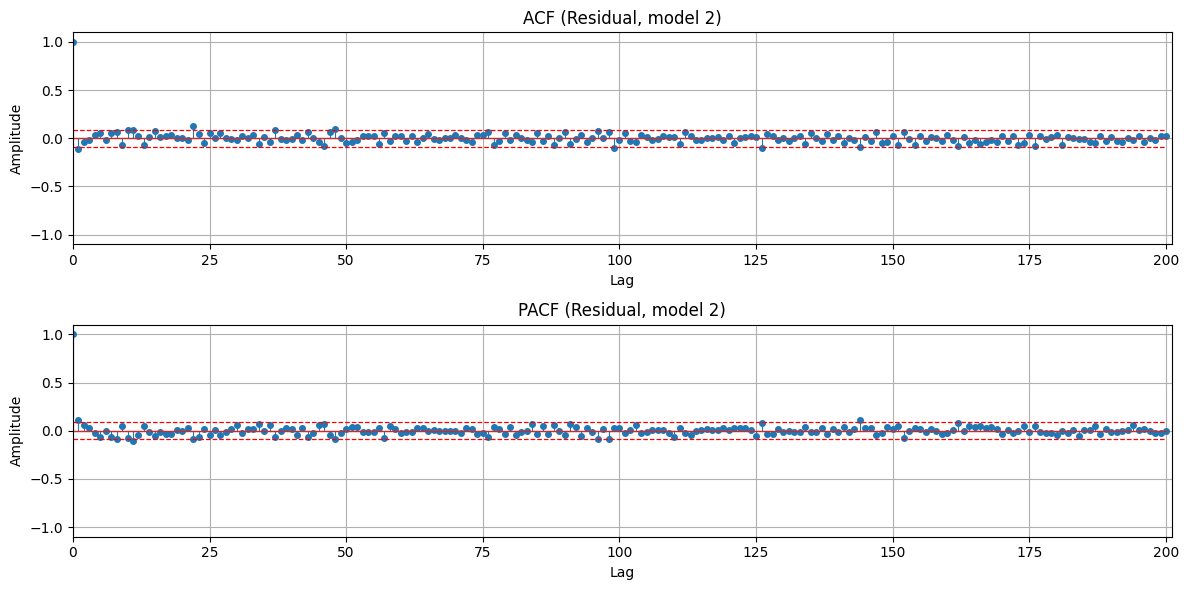

In [23]:
print("=== Model 2: AR(1) with seasonal MA ===")

Cm = np.convolve(dayPoly, weekPoly)
Cm[1:] = 0.3 * Cm[1:]              # Force the model to be stable. Try this if you get odd results.

# Initialize PEM with AR(1) and the specific MA structure
foundmodel2 = PEM(y=powerload, A=Am, C=Cm)

foundmodel2.set_free_params(C_free=np.abs(Cm) > 1e-10) #Ensure that only the relevant coefficients are estimated. Try commenting this line. What happens? 

# Fit the model
result2 = foundmodel2.fit()
result2.summary()

# Compute residuals
ey2 = result2.resid
_= plotACFnPACF(ey2, noLags, 'Residual, model 2')

## Is the resulting model residual white?
It is very close... Perhaps this is a better model than the one below?

In [24]:
whiteness_test(ey2)

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 41.39 < 37.65)
  McLeod-Li test:        False (white if 57.53 < 37.65)
  Monti test:            False (white if 37.96 < 37.65)
  Sign change test:      False (white if 0.55 in [0.46,0.54])


## Make a third model, adding a further periodicity also for the AR-part.
Almost... there seems to be some periodicity at lag 11, lets add that...

=== Model 3: AR(12) with seasonal MA ===
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8444(±0.0268)·z⁻¹ - 0.1096(±0.0478)·z⁻¹¹ + 0.0463(±0.047)·z⁻¹²
C(z) = 1.0 - 0.4852(±0.0422)·z⁻²⁴ - 0.7084(±0.0478)·z⁻¹⁶⁸ + 0.302(±0.059)·z⁻¹⁹²

Polynomial orders: nA = 12    nC = 192
Number of free coefficients: 6
Fit to estimation data (NRMSE): 60.52%
FPE : 0.0  MSE : 0.0
AIC : -2479.661   BIC : -2454.771



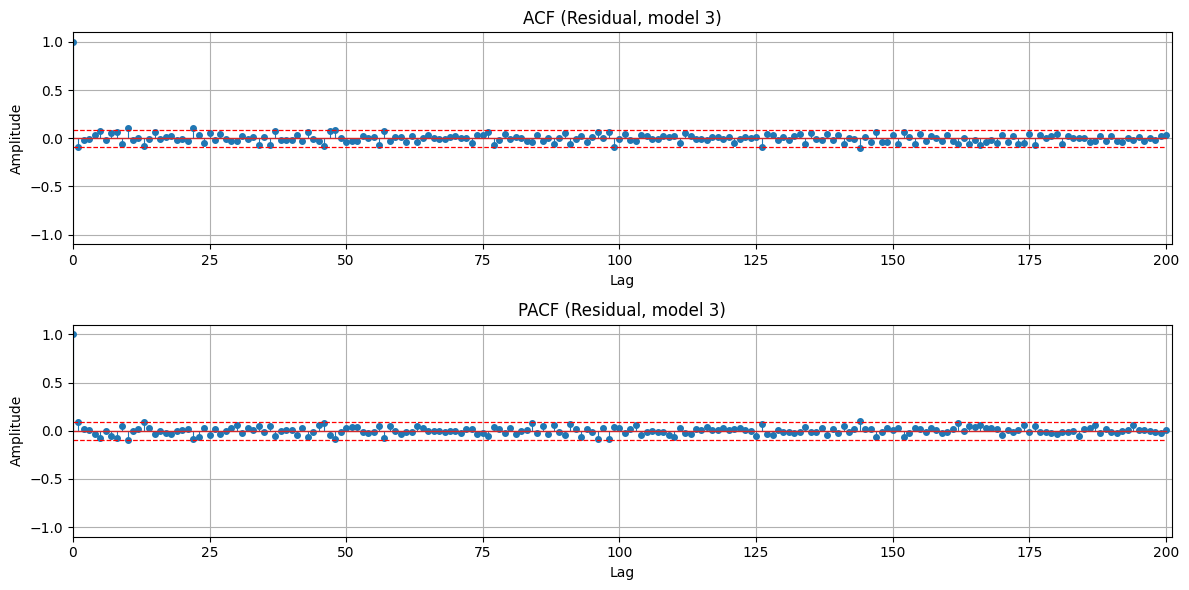

In [25]:
# Model 3: AR(12) with seasonal MA structure
print("=== Model 3: AR(12) with seasonal MA ===")

Am = np.convolve([1, 1], np.concatenate([[1], np.zeros(11-1), [-1]]))
#Am = Am[:-1]

model3 = PEM(y=powerload, A=Am, C=Cm)

model3.set_free_params(A_free=np.abs(Am) > 1e-10, C_free=np.abs(Cm) > 1e-10)

result3 = model3.fit()
result3.summary()

# Compute residuals
ey3 = result3.resid
_= plotACFnPACF(ey3, noLags, 'Residual, model 3')
#check_for_significance(result3)


## Is the resulting model residual white now?
Notice that although the residual is now white, the last coefficient in
the AR polynomial is not significant. Try removing this (adding line 111).
Is the residual still white? Do we need to keep it?

In [26]:
whiteness_test(ey3)

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 31.58 < 37.65)
  McLeod-Li test:        False (white if 55.26 < 37.65)
  Monti test:            True (white if 29.81 < 37.65)
  Sign change test:      True (white if 0.51 in [0.45,0.55])


### Parameter significance check
The cell below computes parameter confidence intervals and reports which estimated coefficients are statistically significant (i.e. the 95% CI does not include zero).
This mirrors MATLAB's `checkForSignificance(foundModel)` by showing significance for each estimated parameter.